In [22]:
from nilearn.connectome import ConnectivityMeasure
from brainspace.utils.parcellation import reduce_by_labels
import numpy as np
import os.path as op
#from numrisk.fmri_analysis.gradients.utils_old import get_events_confounds
import seaborn as sns
import pandas as pd

import nilearn.plotting as nplt
import matplotlib.pyplot as plt

bids_folder = '/mnt_03/ds-dnumrisk' 

# Get Glasser parcellation and mask
from numrisk.fmri_analysis.gradients.utils import get_glasser_CAatlas_mapping, get_glasser_parcels
glasser_CAatlas_mapping, CAatlas_names = get_glasser_CAatlas_mapping()
mask_glasser, labeling_glasser = get_glasser_parcels(space = 'fsaverage5' )

from brainspace.utils.parcellation import map_to_labels
from nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage()

In [53]:
from utils_01 import get_cleanTS_run, get_events_confounds

subject = 3
sub = f'{int(subject):02d}'

DMs = []
TSs = []
for run in range(1, 7):
    try:
        dm = get_events_confounds(sub, ses=1, run=run, bids_folder=bids_folder)
        dm['run'] = run
        ts = get_cleanTS_run(sub, run=run, bids_folder=bids_folder)

        TSs.append(ts)
        DMs.append(dm)
    except:
        print(f'!!! ------ problems for run {run} (sub {sub} )')


dm = pd.concat(DMs) # 1128 timesteps = 188 x 6
dm.index.name = 'onset'
dm.set_index('run',append=True,inplace=True)

TSs = np.array(TSs)
TSs = TSs.transpose(1, 0, 2).reshape(TSs.shape[1], (TSs.shape[0]*TSs.shape[2]))
seed_ts = reduce_by_labels(TSs[mask_glasser], labeling_glasser[mask_glasser], axis=1, red_op='mean',dtype=float)

print(np.shape(seed_ts))
print(np.shape(dm))

A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
(360, 1128)
(1128, 12)


In [15]:
# 1 psy_context

psy_context = 'stimulus2_int'
formula = 'targetTS ~ seedTS + psy_context + seedTS:psy_context'
seed_parcel = 275 - 1

seedTS = seed_ts[seed_parcel]
p_vals = {'seedTS' : [], 'psy_context' : [],'seedTS:psy_context':[]} #, 'distances':[]}
coef = {'seedTS' : [], 'psy_context' : [],'seedTS:psy_context':[]} #, 'distances':[]}

import statsmodels.api as sm
for parcel_n in range(360):
    df_glm = pd.DataFrame(np.array([seedTS, seed_ts[parcel_n], dm[psy_context]]).T, columns = ['seedTS','targetTS','psy_context'])
    result = sm.formula.ols(formula=formula, data=df_glm).fit()
    [p_vals[param].append(result.pvalues[param]) for param in p_vals.keys()]
    [coef[param].append(result.params[param]) for param in coef.keys()]


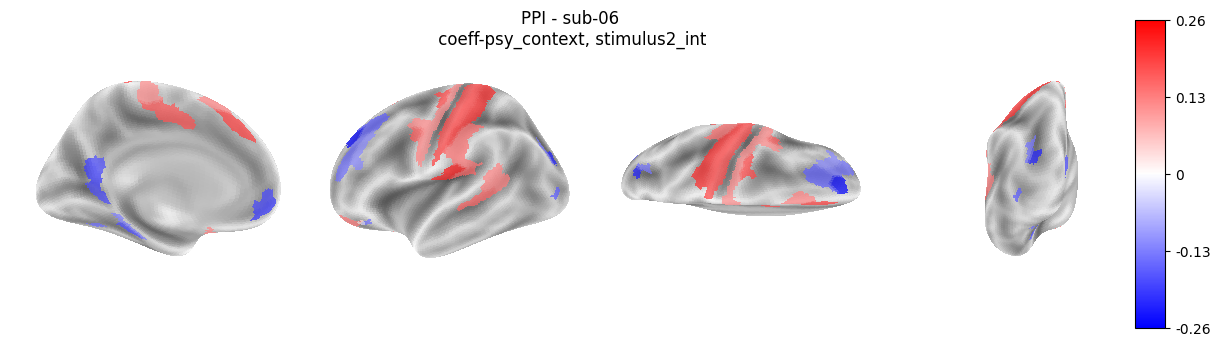

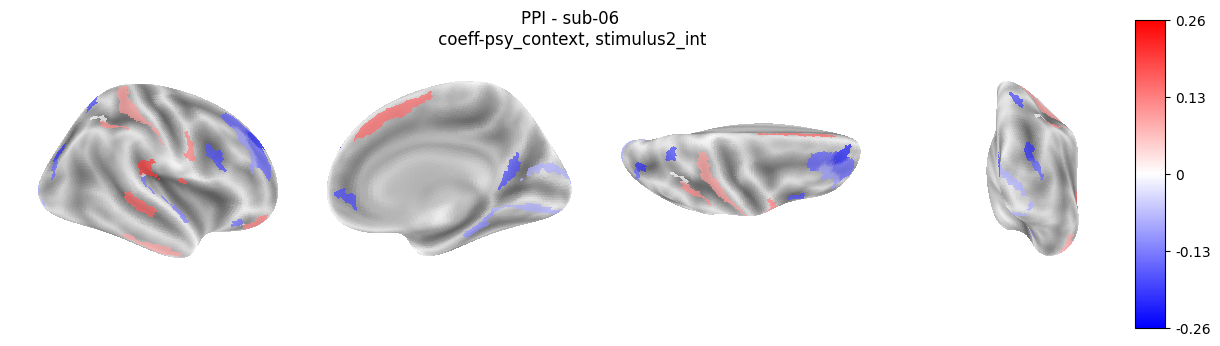

In [16]:
param = 'psy_context'

from brainspace.utils.parcellation import map_to_labels
tstat_cmap = 'bwr'
views = ['medial','lateral','dorsal','posterior']
stats_fsav5 = map_to_labels(np.array(coef[param]), labeling_glasser, mask=mask_glasser, fill=np.nan) # parcel to vertex
p_values_fsav5 = map_to_labels(np.array(p_vals[param]), labeling_glasser, mask=mask_glasser, fill=np.nan) # parcel to vertex
stats_fsav5[p_values_fsav5 > 0.05] = np.nan

for i, hemi in enumerate(['L','R']):
    map = np.split(stats_fsav5,2)[i]
    surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
    bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left
    Tval_extrem = np.max(np.abs(np.nan_to_num(stats_fsav5, nan=0.0, posinf=0.0, neginf=0.0)))
    figure, axes = plt.subplots(nrows=1, ncols=len(views),figsize = (15,8), subplot_kw=dict(projection='3d'))
    for i,view in enumerate(views):
        colbar = True if view == 'posterior' else False
        nplt.plot_surf(surf_mesh=surf_mesh , surf_map= map, vmin=-Tval_extrem, vmax=Tval_extrem,
                view= view,cmap=tstat_cmap, colorbar=colbar, #title=f'sub-{sub}, grad {n_grad+1}',
                bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[i]) 
    figure.subplots_adjust(wspace=0.01)
    figure.suptitle(f'PPI - sub-{sub} \n coeff-{param}, {psy_context} \n', y=0.7) # for p-val < 0.05


psy_context-stim2 activations 
* make sense (left motorcortex!) for sub: 1,2,4,6 | 
* not for sub: 3 (but seedTS activation still fine, prob events off?),5(little)

## Modelling both stimuli simultanously


In [54]:
psy_context1 = 'stimulus1_int'
psy_context2 = 'stimulus2_int'
regressors_names = ['seedTS', 'psy_context1', 'psy_context2', 'seedTS:psy_context1', 'seedTS:psy_context2']
formula = 'targetTS ~ ' + ' + '.join(regressors_names)

seed_parcel = 275 - 1

seedTS = seed_ts[seed_parcel]
p_vals = {param: [] for param in regressors_names}
coef = {param: [] for param in regressors_names}

import statsmodels.api as sm
for parcel_n in range(360):
    df_glm = pd.DataFrame(np.array([seedTS, seed_ts[parcel_n], dm[psy_context1], dm[psy_context2]]).T, columns = ['seedTS','targetTS','psy_context1', 'psy_context2'])
    result = sm.formula.ols(formula=formula, data=df_glm).fit()
    [p_vals[param].append(result.pvalues[param]) for param in p_vals.keys()]
    [coef[param].append(result.params[param]) for param in coef.keys()]

p_vals = {key: np.array(value) for key, value in p_vals.items()}
coef = {key: np.array(value) for key, value in coef.items()}

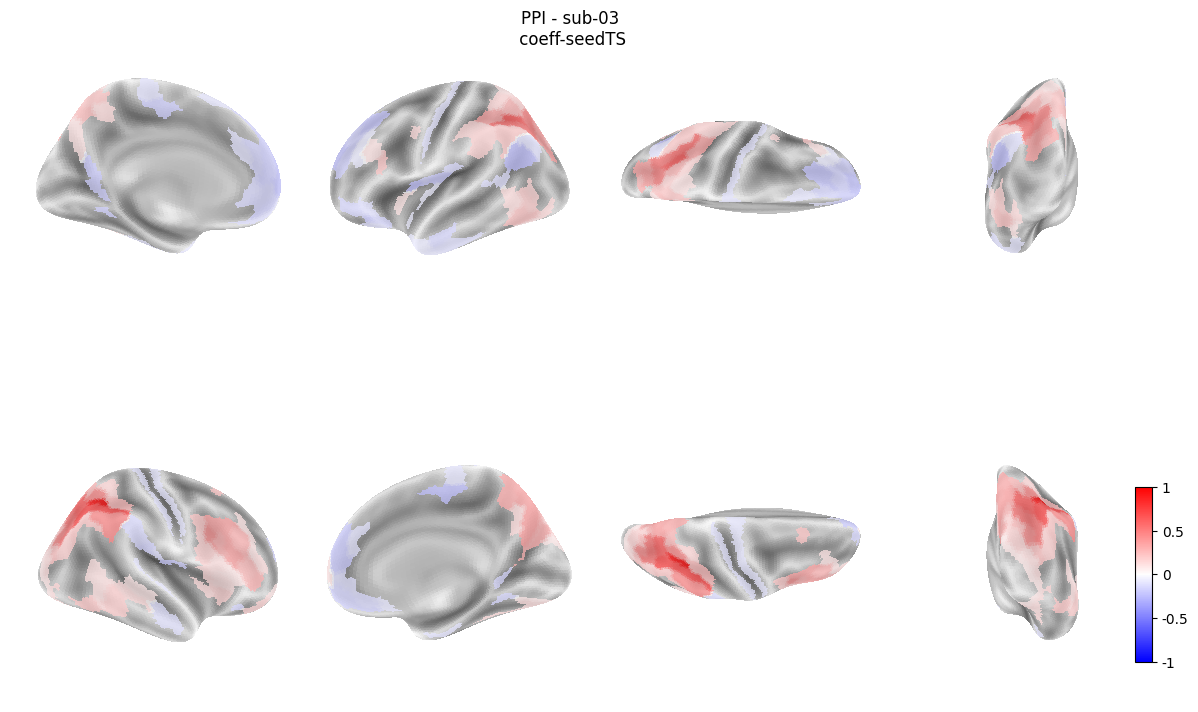

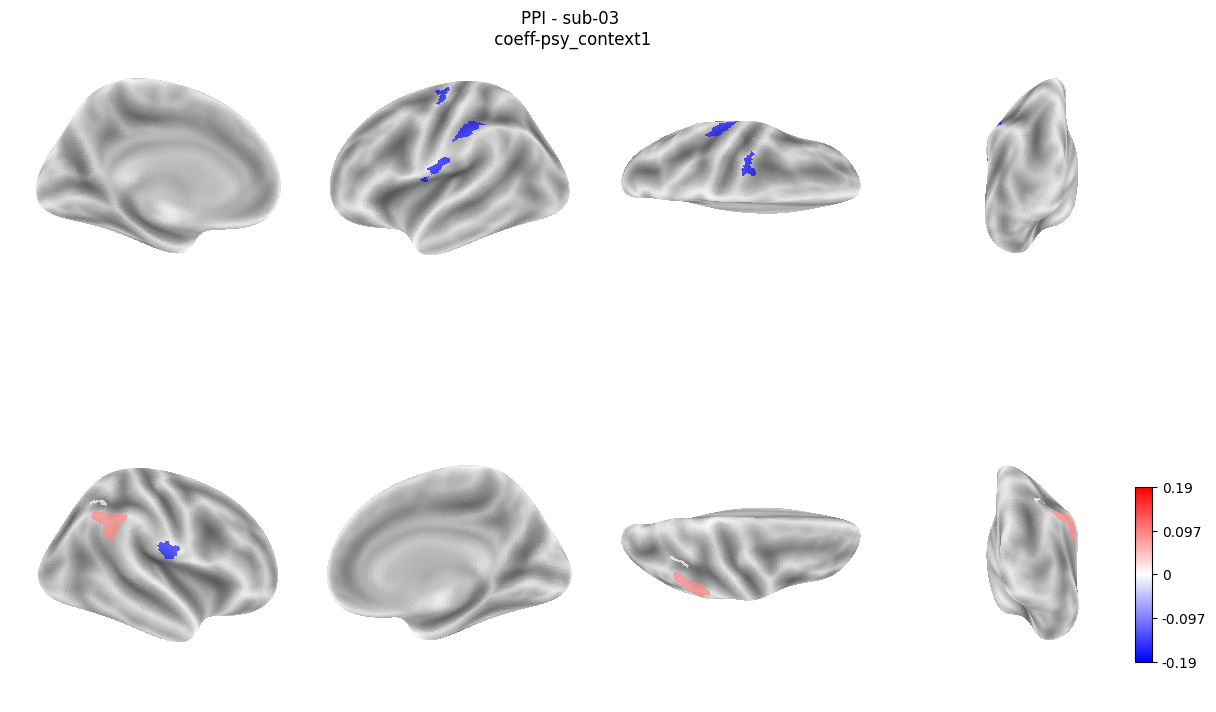

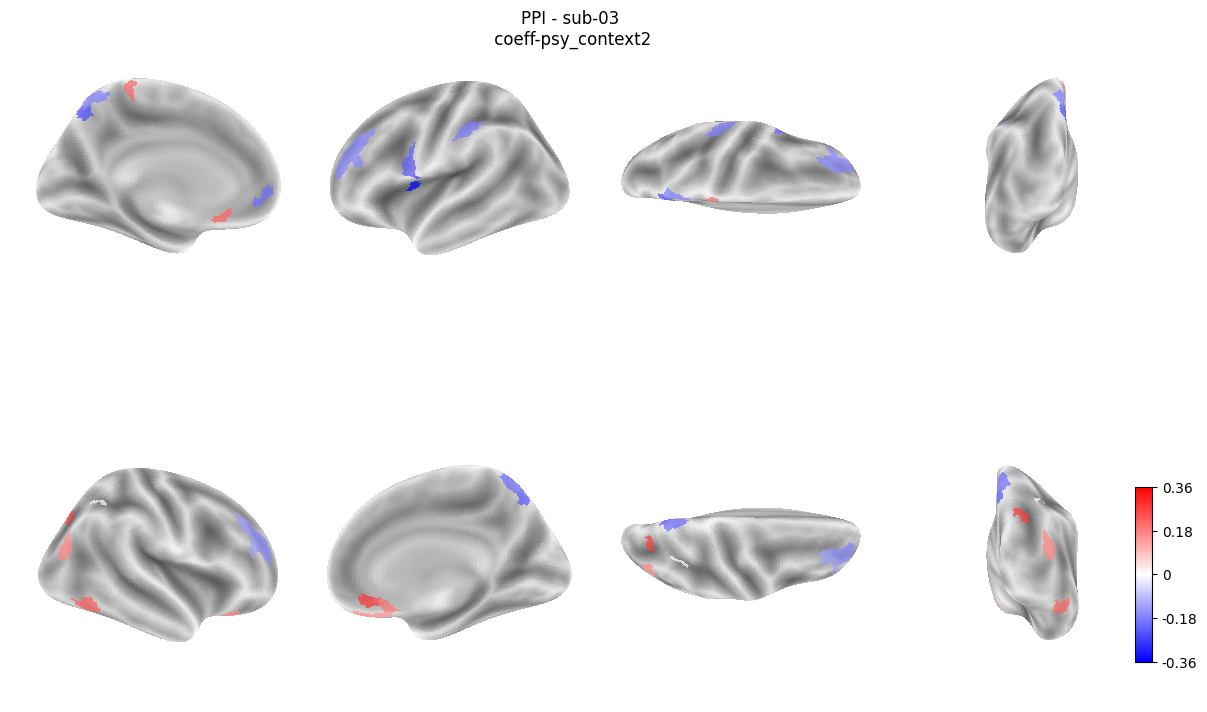

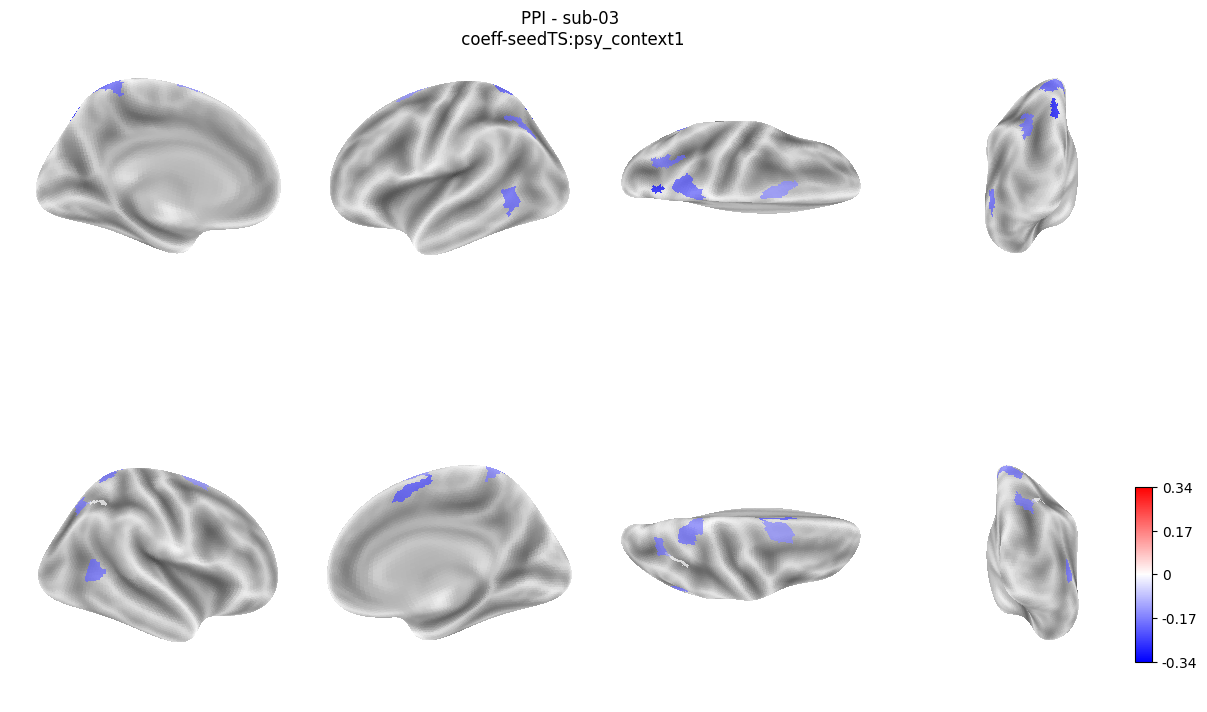

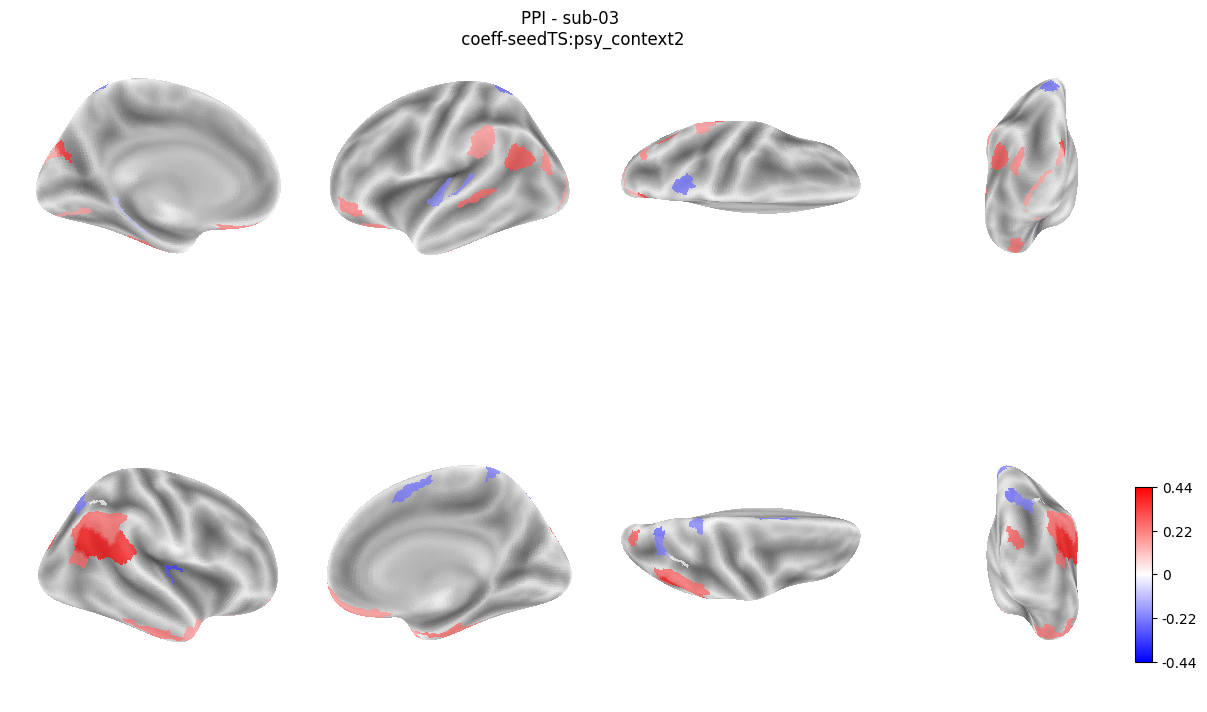

In [55]:
tstat_cmap = 'bwr'
views = ['medial','lateral','dorsal','posterior']

for param in regressors_names:
    stats_fsav5 = map_to_labels(coef[param], labeling_glasser, mask=mask_glasser, fill=np.nan) # parcel to vertex
    p_values_fsav5 = map_to_labels(p_vals[param], labeling_glasser, mask=mask_glasser, fill=np.nan) # parcel to vertex
    stats_fsav5[p_values_fsav5 > 0.05] = np.nan

    figure, axes = plt.subplots(nrows=2, ncols=len(views),figsize = (15,10), subplot_kw=dict(projection='3d'))

    for j, hemi in enumerate(['L','R']):
        map = np.split(stats_fsav5,2)[j]
        surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
        bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left
        Tval_extrem = np.max(np.abs(np.nan_to_num(stats_fsav5, nan=0.0, posinf=0.0, neginf=0.0)))
        for i,view in enumerate(views):
            colbar = True if view == 'posterior' and hemi == 'R' else False
            nplt.plot_surf(surf_mesh=surf_mesh , surf_map= map, vmin=-Tval_extrem, vmax=Tval_extrem,
                    view= view,cmap=tstat_cmap, colorbar=colbar, #title=f'sub-{sub}, grad {n_grad+1}',
                    bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[j,i]) 

    figure.subplots_adjust(wspace=0.01, hspace=0.01)
    figure.suptitle(f'PPI - sub-{sub} \n coeff-{param} \n', y=0.85) # for p-val < 0.05
